# Character Level RNN using LSTM cells.

- Trains on Star Trek episode titles
- Outputs "fake" titles.

Much comes from a [Keras example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py).

## Setup Environment

- Import Keras
- Open up the Star Trek corpus
- Give each leter an index and create dictionaries to translate from index to character.

In [1]:
## Much borrowed from https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
import numpy as np
import random
import sys

text = open("startrekepisodes.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
vocabulary_size = len(chars)
print('total chars:', vocabulary_size)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


# How long is a title?
titles = text.split('\n')
lengths = np.array([len(n) for n in titles])
print("Max:", np.max(lengths))
print("Mean:", np.mean(lengths))
print("Median:", np.median(lengths))
print("Min:", np.min(lengths))

# hence choose 30 as seuence length to train on.

Using TensorFlow backend.


corpus length: 11010
total chars: 49
Max: 50
Mean: 14.0013623978
Median: 13.0
Min: 2


## Setup Training Data

- Cut up the corpus into sequences of 40 characters.
- Change indexes into "one-hot" vector encodings.

In [3]:
# cut the text in semi-redundant sequences of maxlen characters
seq_len = 30
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len])
    next_chars.append(text[i + seq_len])
print('nb sequences:', len(sentences))

X = np.zeros((len(sentences), seq_len), dtype=int)
y = np.zeros((len(sentences), vocabulary_size), dtype=np.bool)

for i in range(len(sentences)):
    X[i] = np.array([char_indices[x] for x in sentences[i]])
    y[i, char_indices[next_chars[i]]] = True

print("Done preparing training corpus, shapes of sets are:")
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))
print("Vocabulary of characters:", vocabulary_size)

nb sequences: 3660
Done preparing training corpus, shapes of sets are:
X shape: (3660, 30)
y shape: (3660, 49)
Vocabulary of characters: 49


## Model

- Model has one hidden layer of 128 LSTM cells.
- Input layer is an Embedding to convert from indices to a vector encoding automatically (common trick - but does it work?)

In [8]:
layer_size = 128
dropout_rate = 0.5
# build the model: a single LSTM
print('Build model...')
model_train = Sequential()
model_train.add(Embedding(vocabulary_size, layer_size, input_length=maxlen))

# LSTM part
model_train.add(LSTM(layer_size, return_sequences=True))
model_train.add(LSTM(layer_size))

# Project back to vocabulary
model_train.add(Dense(vocabulary_size))
model_train.add(Activation('softmax'))
model_train.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_train.summary()



Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 128)           6272      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 49)                6321      
_________________________________________________________________
activation_4 (Activation)    (None, 49)                0         
Total params: 275,761
Trainable params: 275,761
Non-trainable params: 0
_________________________________________________________________


## Training

- Train on batches of 128 examples

In [9]:
# Training the Model.
model_train.fit(X, y, batch_size=64, epochs=10)

Epoch 1/10
3660/3660 [==============================] - 6s 2ms/step - loss: 3.2456
Epoch 2/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.9933
Epoch 3/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.7041
Epoch 4/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.4996
Epoch 5/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.3949
Epoch 6/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.2981
Epoch 7/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.2025
Epoch 8/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.0798
Epoch 9/10
3660/3660 [==============================] - 4s 1ms/step - loss: 1.9792
Epoch 10/10
3660/3660 [==============================] - 4s 1ms/step - loss: 1.8568


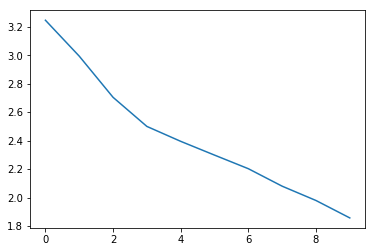

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(model_train.history.history['loss'])

In [12]:
# Save model if necessary
model_train.save("keras-startrek-LSTM-model.h5")

## Test the Model

- Take a quote then add 400 characters.

### Make a Decoder model

- Needs input length of 1.
- Needs batch size of 1
- Needs LSTM to be stateful
- check that params is the same as model_train

In [5]:
# Load model if necessary.
model_train = load_model("keras-startrek-LSTM-model.h5")

In [15]:
# Build a decoding model (input length 1, batch size 1, stateful)

model_dec = Sequential()
model_dec.add(Embedding(vocabulary_size, layer_size, input_length=1, batch_input_shape=(1,1)))

# LSTM part
model_dec.add(LSTM(layer_size, stateful=True, return_sequences=True))
model_dec.add(LSTM(layer_size, stateful=True))

# project back to vocabulary
model_dec.add(Dense(vocabulary_size, activation='softmax'))
model_dec.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_dec.summary()

# set weights from training model
model_dec.set_weights(model_train.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, 1, 128)               6272      
_________________________________________________________________
lstm_9 (LSTM)                (1, 1, 128)               131584    
_________________________________________________________________
lstm_10 (LSTM)               (1, 128)                  131584    
_________________________________________________________________
dense_5 (Dense)              (1, 49)                   6321      
Total params: 275,761
Trainable params: 275,761
Non-trainable params: 0
_________________________________________________________________


In [16]:
## Sampling function

def sample_model(seed, model_name, length=400):
    '''Samples a charRNN given a seed sequence.'''
    generated = ''
    sentence = seed.lower()[:]
    generated += sentence
    print("Seed: ", generated)
    
    for i in range(length):
        x = np.array([char_indices[n] for n in sentence])
        x = np.reshape(x,(1,1))
        preds = model_name.predict(x, verbose=0)[0]
        next_index = sample(preds, 0.5)
        next_char = indices_char[next_index]
        
        generated += next_char
        sentence = sentence[1:] + next_char
    print("Generated: ", generated)

In [17]:
# Sample 1000 characters from the model using a random seed from the vocabulary.
sample_model(indices_char[random.randint(0,vocabulary_size-1)], model_dec, 1000)

Seed:  (
Generated:  (aieter
the paardor
the parsimer port onime parssion
the weardimen of murg
of the pird soird sumil
the pars
the part 1)
invigion
the wirds part 1)
part 1)
part 1.1
part 1)
parkace
simplice
star
the part i)
parspirk
the paar par
corsond
miger
the part 1)
incinater
mird vorim meris
the part 1)
part 11)
homil
the dight
armone to parssion
mighs
the pars
the morder
the purday
parspar
the percore
the parsier
morm
the pars
ay
the parsior
pright
amith
the parsirin deard
risgad
the parsir merorpay
the pissing
the pars
and lear
the part 1)
ard ument
darker the part 1)
the pargime
the part 1part 1)
emenciry
the moncing
of pirki
the parsilring
the parsity
moring
burd parsint
the pars osd
ampurel
the park part i
part 1): part one
part i)
imber
the part 1)
part 1)
scepeer
the peation
the pard pars of wingnur
the parsil mor
mirr
the pards part part 1)
dird surdindor
the pars
the virginc
the part 1briger
scirn
wont unqing
the pars, part 1)
part i)
the part 1)
parsilit part 1)
pror

## Experiments - Model Maker

A single function to make both training and running models.

In [18]:
def model_maker(model, layer_size=64, dropout_rate=0.5, num_layers=1, vocab_size=20, input_length=1, lr=0.01, train_mode=True):
    """Builds a charRNN model with variable layer size, number of layers, droupout, learning rate, and a training mode."""
    if train_mode:
        stateful = False
        input_shape = (None, input_length)
    else:
        stateful = True
        input_shape = (1, input_length)
    
    # Input embedding
    model.add(Embedding(vocab_size, layer_size, input_length=input_length, batch_input_shape=input_shape))
              
    # LSTM layers + 1
    for i in range(num_layers - 1):
        model.add(Dropout(dropout_rate))
        model.add(LSTM(layer_size, return_sequences=True, stateful=stateful))
    
    # Final LSTM layer
    model.add(Dropout(dropout_rate))
    model.add(LSTM(layer_size, stateful=stateful))

    # Project back to vocabulary
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr))
    model.summary()

# m = Sequential()
# model_maker(m, layer_size=128, vocab_size=vocabulary_size, input_length=30, train_mode=True)
# m.fit(X, y, batch_size=64, epochs=5)